Bu versiyondaa Glove Kütüphanesi ile denenicek

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import defaultdict
from collections import  Counter
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix


pd.set_option('display.max_rows', 5000000)
pd.set_option('display.max_columns', 5000000)
pd.set_option('display.width', 10000000)
pd.set_option('display.max_colwidth', 4000)

Using TensorFlow backend.


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
target = pd.read_csv("train.csv")
sample = pd.read_csv("sample.csv")

df=pd.concat([train,test])
df.drop(["label", "id"],axis=1,inplace=True)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [3]:
# @ ile başlayan kelimelerin hepsini dopladık

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt    

df['tweet'] = np.vectorize(remove_pattern)(df['tweet'], "@[\w]*")

In [4]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [5]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [6]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    
    return url.sub(r'',text)

In [7]:
df['tweet']=df['tweet'].apply(lambda x: remove_emoji(x))

In [8]:
df['tweet']=df['tweet'].apply(lambda x : remove_punct(x))

In [9]:
df['tweet']=df['tweet'].apply(lambda x : remove_URL(x))

In [10]:
df["tweet"]=df["tweet"].str.replace("[^A-Za-z]"," ")

In [11]:
df["tweet"] = df["tweet"].str.replace(r"\b[a-zA-Z]\b", "")

In [12]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')
df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

In [13]:
from textblob import Word
#nltk.download('wordnet')
df['tweet'] = df['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 

In [14]:
sil = pd.Series(' '.join(df['tweet']).split()).value_counts()[-39000:]
df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

In [15]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['tweet']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [16]:
from tqdm import tqdm

corpus=create_corpus(df)

100%|██████████████████████████████████████████████████████████████████████████| 49159/49159 [00:06<00:00, 7411.64it/s]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
embedding_dict={}
with open('C:\\Users\\MONSTER\\Documents\\PY\\NLP\\Anality-Data-Twitter-Sentiment\\glove.6B.100d.txt','r',encoding="utf8") as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
    f.close()

In [18]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [19]:
tweet_pad

array([[  13, 3170, 4442, ...,    0,    0,    0],
       [  92, 5911, 1952, ...,    0,    0,    0],
       [  17, 2703,    0, ...,    0,    0,    0],
       ...,
       [ 676,    9,    4, ...,    0,    0,    0],
       [   3,   28,  317, ...,    0,    0,    0],
       [ 237,  703,  105, ...,    0,    0,    0]])

In [20]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 9794


In [21]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████████████████████████████████████████████████████████████████████| 9794/9794 [00:00<00:00, 351006.68it/s]


In [22]:
np.shape(embedding_matrix)

(9795, 100)

In [44]:
# Weight Oluşrma

no_claim_count, claim_count = np.bincount(target.label)
total_count = len(target.label)
weight_no_claim = (1 / no_claim_count) * (total_count) / 2.0
weight_claim = (1 / claim_count) * (total_count) / 2.0
class_weights = {0: weight_no_claim, 1: weight_claim}

In [63]:
import tensorflow as tf
from tensorflow import keras

model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy',tf.metrics.Recall(),tf.metrics.Precision()])

In [64]:
train=tweet_pad[:train.shape[0]]
test=tweet_pad[train.shape[0]:]

In [65]:
target = pd.read_csv("train.csv")


X_train,X_test,y_train,y_test=train_test_split(train,target['label'].values,test_size=0.25)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (23971, 50)
Shape of Validation  (7991, 50)


In [66]:
history=model.fit(X_train,y_train,batch_size=256,class_weight=class_weights,epochs=12,validation_data=(X_test,y_test),verbose=2)

Train on 23971 samples, validate on 7991 samples
Epoch 1/12
 - 13s - loss: 0.6912 - accuracy: 0.6082 - recall_5: 0.5026 - precision_3: 0.0652 - val_loss: 0.6931 - val_accuracy: 0.8105 - val_recall_5: 0.3105 - val_precision_3: 0.0646
Epoch 2/12
 - 12s - loss: 0.6912 - accuracy: 0.8821 - recall_5: 0.2264 - precision_3: 0.0627 - val_loss: 0.6929 - val_accuracy: 0.9280 - val_recall_5: 0.1660 - val_precision_3: 0.0623
Epoch 3/12
 - 11s - loss: 0.6912 - accuracy: 0.9025 - recall_5: 0.1380 - precision_3: 0.0625 - val_loss: 0.6929 - val_accuracy: 0.9280 - val_recall_5: 0.1159 - val_precision_3: 0.0624
Epoch 4/12
 - 11s - loss: 0.6912 - accuracy: 0.9034 - recall_5: 0.1034 - precision_3: 0.0627 - val_loss: 0.6928 - val_accuracy: 0.9285 - val_recall_5: 0.0916 - val_precision_3: 0.0626
Epoch 5/12
 - 12s - loss: 0.6912 - accuracy: 0.9262 - recall_5: 0.0817 - precision_3: 0.0625 - val_loss: 0.6927 - val_accuracy: 0.9285 - val_recall_5: 0.0733 - val_precision_3: 0.0625
Epoch 6/12
 - 11s - loss: 0.691

In [49]:
predictions = model.predict_classes(X_test)

In [50]:
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

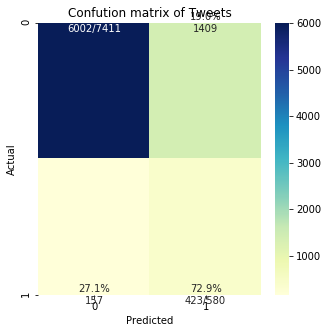

In [51]:
plot_cm(y_test,predictions, 'Confution matrix of Tweets', figsize=(5,5))

In [67]:
y_pred = model.predict_classes(test)

In [85]:
sonuc = pd.DataFrame(data = y_pred, index = range(17197), columns=["label"] )

In [86]:
submission=pd.read_csv('sample.csv')
id = submission[["id"]]

In [87]:
s2= pd.concat([id,sonuc],axis=1)
s2.to_csv('210620_2.csv',index=False)

In [88]:
s2.head()

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0
